# Breast Cancer Classification

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
os.getcwd()

'/kaggle/working'

shutil.rmtree("./Cancer/")

In [5]:
#Loading the text file
fold_df = pd.read_csv("../input/breakhis/Folds.csv")

In [6]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [7]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

,fold,mag,grp,path
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [8]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

**Info:**

- From the path column we can extract the exact file name using apply and split functions on the path column.
- And also the class is extracted.

In [9]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [10]:
fold_df.head(3)

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign


In [11]:
#Creating new directory
os.makedirs("../Cancer/")

In [12]:
!pwd

/kaggle/working


In [13]:
#Moving all the images to one folder
for p in fold_df['path']:
    src = "../input/breakhis/BreaKHis_v1/" + p
    dest = "../Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)    

In [14]:
#Checking the len
len(os.listdir("../cancer/"))

7909

In [15]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [16]:
#Printing the head to display the changed made
fold_df.head(3)

,fold,mag,grp,path,filename,label,file_loc,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign,benign_SOB_B_A-14-22549AB-100-003.png,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


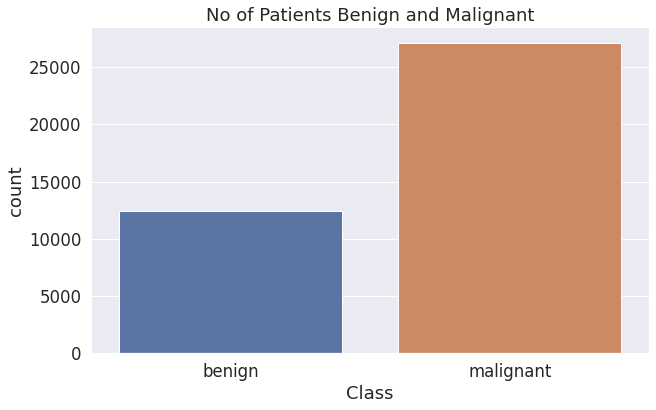

In [17]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(fold_df['label']);
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

- Data is Highly Imabalanced 

In [18]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

In [19]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("../Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0] if x.split('_')[0] == 'malignant' else 'benign')
df['class'] = df['label'].apply(lambda x: 1 if x =='malignant' else 0)
df.set_index("file_loc",inplace=True)

In [20]:
#Checking the data frame
df.head()

,label,class
file_loc,,
malignant_SOB_M_PC-14-12465-100-013.png,malignant,1
malignant_SOB_M_LC-14-15570C-100-002.png,malignant,1
malignant_SOB_M_MC-14-19979C-400-007.png,malignant,1
malignant_SOB_M_LC-14-13412-100-018.png,malignant,1
malignant_SOB_M_DC-14-20636-200-026.png,malignant,1


- Using the data frame, the splitting for train, test and validation is done.
- 10% is kept aside as the test data, and 10% as validation data.
- 80% is taken as the training data.

In [21]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val"
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [22]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 2)
Validation size : (712, 2)
Testing size : (791, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


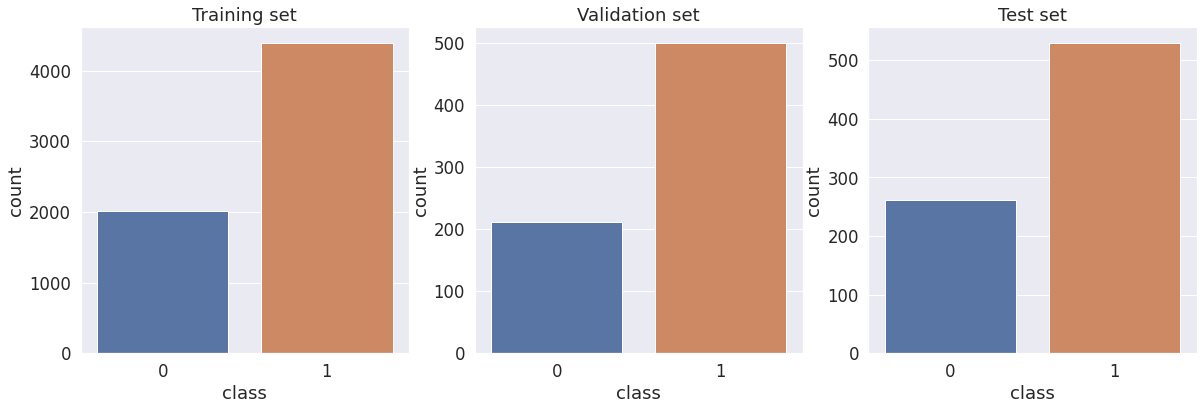

In [23]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

In [24]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [25]:
train_has_cancer.head()

,label,class
file_loc,,
malignant_SOB_M_DC-14-13412-400-009.png,malignant,1
malignant_SOB_M_PC-14-19440-40-019.png,malignant,1
malignant_SOB_M_DC-14-20629-200-019.png,malignant,1
malignant_SOB_M_PC-14-15687B-400-002.png,malignant,1
malignant_SOB_M_DC-14-18650-40-028.png,malignant,1


In [26]:
train_has_cancer.shape

(4398, 2)

In [27]:
train_has_no_cancer.shape

(2008, 2)

In [28]:
#Upsampling the minority class by the size of majority class with replacement
# train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), 
#                                      random_state = 47, replace = True)

In [29]:
!ls ../input

breakhis


In [30]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img_to_augment = []
for file_name in train_has_no_cancer.index:
    print(file_name)
    img = load_img('../Cancer/'+file_name)
    x = img_to_array(img)
    img_to_augment.append(x)
#     break

benign_SOB_B_A-14-22549CD-400-028.png
benign_SOB_B_F-14-21998CD-200-008.png
benign_SOB_B_TA-14-19854C-200-009.png
benign_SOB_B_F-14-14134-40-011.png
benign_SOB_B_F-14-14134-100-031.png
benign_SOB_B_F-14-23060CD-400-015.png
benign_SOB_B_TA-14-15275-200-001.png
benign_SOB_B_A-14-22549CD-100-016.png
benign_SOB_B_A-14-22549CD-40-018.png
benign_SOB_B_F-14-14134-200-025.png
benign_SOB_B_PT-14-22704-100-004.png
benign_SOB_B_PT-14-22704-400-023.png
benign_SOB_B_PT-14-21998AB-400-033.png
benign_SOB_B_F-14-9133-400-005.png
benign_SOB_B_F-14-14134E-100-031.png
benign_SOB_B_F-14-23060AB-100-022.png
benign_SOB_B_A-14-22549CD-200-026.png
benign_SOB_B_F-14-29960AB-400-015.png
benign_SOB_B_F-14-14134-100-001.png
benign_SOB_B_PT-14-21998AB-40-040.png
benign_SOB_B_TA-14-15275-100-014.png
benign_SOB_B_TA-14-13200-400-004.png
benign_SOB_B_F-14-14134-400-025.png
benign_SOB_B_A-14-22549AB-40-002.png
benign_SOB_B_F-14-21998CD-400-012.png
benign_SOB_B_TA-14-13200-100-010.png
benign_SOB_B_TA-14-21978AB-400-007

In [31]:
img_to_augment = np.array(img_to_augment)
print(img_to_augment.shape)

(2008, 460, 700, 3)


In [32]:
!mkdir preview

In [33]:
#oversampling using fixed rotation and saclling
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# img = load_img('../Cancer/benign_SOB_B_A-14-22549AB-100-001.png') 
# x = img_to_array(img)  
# x = x.reshape((1,) + x.shape)  
# print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(img_to_augment, batch_size=2000,
                          save_to_dir='preview', save_prefix='augmented_ben', save_format='png'):
    i += 1
    print(batch.shape)
    if i > 1:
        break  # otherwise the generator would loop indefinitely


(2000, 460, 700, 3)
(8, 460, 700, 3)


In [34]:
!cd preview && ls

augmented_ben_0_6172.png     augmented_ben_1904_8790.png
augmented_ben_1000_236.png   augmented_ben_1905_55.png
augmented_ben_1001_8318.png  augmented_ben_1906_4398.png
augmented_ben_1002_5598.png  augmented_ben_1907_7044.png
augmented_ben_1003_593.png   augmented_ben_1908_2363.png
augmented_ben_1004_131.png   augmented_ben_1909_8096.png
augmented_ben_1005_367.png   augmented_ben_190_8330.png
augmented_ben_1006_1753.png  augmented_ben_1910_526.png
augmented_ben_1007_6267.png  augmented_ben_1911_7715.png
augmented_ben_1008_3494.png  augmented_ben_1912_8691.png
augmented_ben_1009_6212.png  augmented_ben_1913_439.png
augmented_ben_100_7519.png   augmented_ben_1914_7332.png
augmented_ben_1010_6240.png  augmented_ben_1915_5796.png
augmented_ben_1011_3450.png  augmented_ben_1916_6803.png
augmented_ben_1012_4213.png  augmented_ben_1917_1906.png
augmented_ben_1013_4284.png  augmented_ben_1918_5134.png
augmented_ben_1014_4205.png  augmented_ben_1919_6247.png
augmented_ben_1015_5733.png  augment

In [35]:
augmented_benign = pd.DataFrame(os.listdir('preview'))
augmented_benign = augmented_benign.rename(columns = {0:'file_loc'})
augmented_benign['label'] = 'benign'
augmented_benign['class'] = 0
augmented_benign.set_index("file_loc",inplace=True)

In [36]:
augmented_benign.head()

,label,class
file_loc,,
augmented_ben_331_1419.png,benign,0
augmented_ben_708_6408.png,benign,0
augmented_ben_1015_5733.png,benign,0
augmented_ben_1503_8902.png,benign,0
augmented_ben_625_5962.png,benign,0


In [37]:
train_has_no_cancer_upsample = pd.concat([train_has_no_cancer, augmented_benign])
train_has_no_cancer_upsample.head()

,label,class
file_loc,,
benign_SOB_B_A-14-22549CD-400-028.png,benign,0
benign_SOB_B_F-14-21998CD-200-008.png,benign,0
benign_SOB_B_TA-14-19854C-200-009.png,benign,0
benign_SOB_B_F-14-14134-40-011.png,benign,0
benign_SOB_B_F-14-14134-100-031.png,benign,0


In [38]:
train_has_no_cancer_upsample.tail()

,label,class
file_loc,,
augmented_ben_1081_1149.png,benign,0
augmented_ben_1491_1109.png,benign,0
augmented_ben_1602_3976.png,benign,0
augmented_ben_1218_6470.png,benign,0
augmented_ben_1229_425.png,benign,0


In [39]:
train_has_no_cancer_upsample.shape

(4016, 2)

In [40]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

In [41]:
data_train['class'].value_counts()

1    4398
0    4016
Name: class, dtype: int64

- As expected the training data is balanced.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


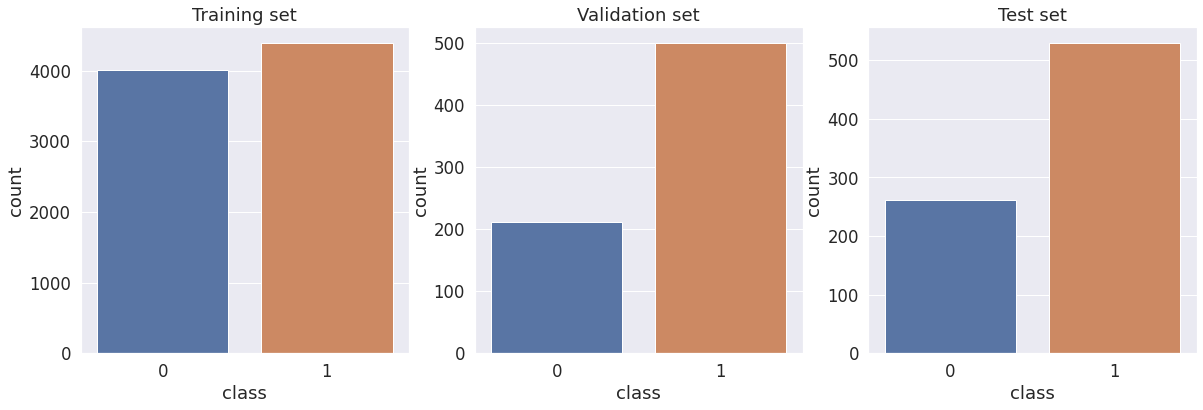

In [42]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

In [43]:
!cd preview && mv *.png ../../Cancer/

In [44]:
!cd ../Cancer/ && ls

augmented_ben_0_6172.png
augmented_ben_1000_236.png
augmented_ben_1001_8318.png
augmented_ben_1002_5598.png
augmented_ben_1003_593.png
augmented_ben_1004_131.png
augmented_ben_1005_367.png
augmented_ben_1006_1753.png
augmented_ben_1007_6267.png
augmented_ben_1008_3494.png
augmented_ben_1009_6212.png
augmented_ben_100_7519.png
augmented_ben_1010_6240.png
augmented_ben_1011_3450.png
augmented_ben_1012_4213.png
augmented_ben_1013_4284.png
augmented_ben_1014_4205.png
augmented_ben_1015_5733.png
augmented_ben_1016_9849.png
augmented_ben_1017_7381.png
augmented_ben_1018_715.png
augmented_ben_1019_2861.png
augmented_ben_101_1372.png
augmented_ben_1020_7873.png
augmented_ben_1021_4125.png
augmented_ben_1022_4280.png
augmented_ben_1023_4009.png
augmented_ben_1024_5423.png
augmented_ben_1025_7864.png
augmented_ben_1026_3684.png
augmented_ben_1027_7388.png
augmented_ben_1028_1675.png
augmented_ben_1029_4567.png
augmented_ben_102_3912.png
augmented_ben_1030_5695.png
augmented_ben_1031_7345.png
aug

In [45]:
data_train.shape

(8414, 2)

## Creating the directory structure for Training , Validation and Testing:

In [46]:
#Creating the directories to store images
os.makedirs("../Cancer_train")
os.makedirs("../Cancer_test")
os.makedirs("../Cancer_validation")
os.makedirs("../Cancer_train/benign")
os.makedirs("../Cancer_train/malignant")
os.makedirs("../Cancer_validation/benign")
os.makedirs("../Cancer_validation/malignant")
os.makedirs("../Cancer_test/benign")
os.makedirs("../Cancer_test/malignant")

In [47]:
df.label.value_counts()

malignant    5429
benign       2480
Name: label, dtype: int64

In [48]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = data_train.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:          
            label = 'benign'      
        src = os.path.join("../Cancer/",img)
        dest = os.path.join("../Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

In [49]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

In [50]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_test/",label,img)
    shutil.copyfile(src,dest)

In [51]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("../Cancer_train/benign/")))
print("Malignant::",len(os.listdir("../Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("../Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("../Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_test/malignant/")))

Training Data:
 
Benign: 4016
Malignant:: 4398
 
Validation Data
 
Benign size: 211
Malignant size : 501
 
Testing Data:
 
Benign size : 261
Malignant size : 530


In [52]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [53]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("../Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("../Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8414 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


# CNN

In [54]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

2023-01-23 09:54:32.393001: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0

In [55]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

## **Model Compilation**

In [56]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [57]:
#Model is fitted using train and validation generator for 35 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=50 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

2023-01-23 09:54:33.808487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
263/263 [==============================] - 245s 927ms/step - loss: 0.6119 - accuracy: 0.6386 - val_loss: 0.4741 - val_accuracy: 0.7879


2023-01-23 09:58:40.332108: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
263/263 [==============================] - 312s 1s/step - loss: 0.4304 - accuracy: 0.8174 - val_loss: 0.4965 - val_accuracy: 0.7640
Epoch 3/50
263/263 [==============================] - 302s 1s/step - loss: 0.4045 - accuracy: 0.8239 - val_loss: 0.4917 - val_accuracy: 0.7935
Epoch 4/50
263/263 [==============================] - 246s 933ms/step - loss: 0.3883 - accuracy: 0.8344 - val_loss: 0.4668 - val_accuracy: 0.7907
Epoch 5/50
263/263 [==============================] - 307s 1s/step - loss: 0.3791 - accuracy: 0.8387 - val_loss: 0.4098 - val_accuracy: 0.8413
Epoch 6/50
263/263 [==============================] - 218s 829ms/step - loss: 0.3632 - accuracy: 0.8451 - val_loss: 0.4048 - val_accuracy: 0.8385
Epoch 7/50
263/263 [==============================] - 213s 811ms/step - loss: 0.3586 - accuracy: 0.8474 - val_loss: 0.3992 - val_accuracy: 0.8287
Epoch 8/50
263/263 [==============================] - 216s 819ms/step - loss: 0.3361 - accuracy: 0.8598 - val_loss: 0.3766 - val_accu

## Model Results 

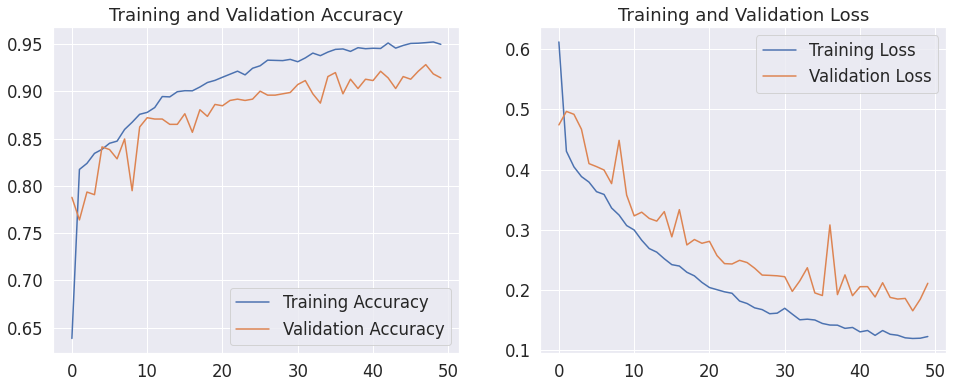

In [58]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing 

In [59]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [60]:
pred = cancer_model.evaluate(test_gen)

791/791 [==============================] - 22s 28ms/step - loss: 0.1963 - accuracy: 0.9191
